<a href="https://colab.research.google.com/github/VaneezaAhmad/Text-Prediction/blob/main/Urdu_predictive_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import in relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import nltk

In [3]:
import spacy

In [38]:
import tensorflow as tf


In [23]:
from nltk.probability import FreqDist

In [39]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [46]:
import pickle
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop

# Read in data

In [ ]:
import glob

def read_first_line(file):
    """Gets the first line from a file.

    Returns
    -------
    str
        the first line text of the input file
    """
    with open(file, 'rt') as fd:
        first_line = fd.readline()
    return first_line

def merge_per_folder(folder_path, output_filename):
    """Merges first lines of text files in one folder, and
    writes combined lines into new output file

    Parameters
    ----------
    folder_path : str
        String representation of the folder path containing the text files.
    output_filename : str
        Name of the output file the merged lines will be written to.
    """
    # make sure there's a slash to the folder path 
    folder_path += "" if folder_path[-1] == "/" else "/"
    # get all text files
    txt_files = glob.glob(folder_path + "*.txt")
    # get first lines; map to each text file (sorted)
    output_strings = map(read_first_line, sorted(txt_files))
    output_content = "".join(output_strings)
    # write to file
    with open(folder_path + output_filename, 'wt') as outfile:
        outfile.write(output_content)

In [4]:
from google.colab import files
uploaded = files.upload()


Saving data.txt to data.txt


In [ ]:
# read_first_line("urdu-data/1.txt")

In [ ]:
merge_per_folder("urdu-data", "data.txt")

FileNotFoundError: ignored

In [5]:
urdu =  open("data.txt", "r", encoding="utf_8").read()

In [6]:
len(urdu)

147477

# Preprocessing

## Spacy

In [7]:
nlp = spacy.blank("ur")

In [8]:
doc = nlp(urdu)

In [9]:
punctuation=["۔؟،\nn\1234567890"]

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
urdu_words = [token.text for token in doc if token.text not in "′″،۔؟،ء\n-\n\n-.\n ./;:°،ء'"]


In [13]:
urdu_words = [token for token in urdu_words if token not in "،‘‘..{.,′″،/،ء'،./°،ء'.-""'-.[\‘‘؎،)‘"]


In [24]:
urdu_words = [token for token in urdu_words if token not in "·èøēŁłąśóżóțŁ'ù'ó'à'Î'é"]

In [27]:
urdu_words = [token for token in urdu_words if token not in "،،\n \n،,\n,,\n\n,,,\n\n\n,,,,\n\n\n\n\t\t\t\t\t\t\t\t\n"]

In [30]:
urdu_words = [token for token in urdu_words if token not in ")‘‘کوما': 2؛)‘‘کوما)‘‘شونین)‘‘شونین': 1"]

In [17]:
urdu_words = [token for token in urdu_words if token not in string.punctuation]

In [18]:
urdu_words = [word.translate(str.maketrans('', '', '..."0123456789!+-')) \
                  for word in urdu_words]

In [19]:
urdu_words = [word.translate(str.maketrans('', '', 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')) \
                  for word in urdu_words]

In [20]:
urdu_words=[word for word in urdu_words if word != '']

In [21]:
len(urdu_words)

29192

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)


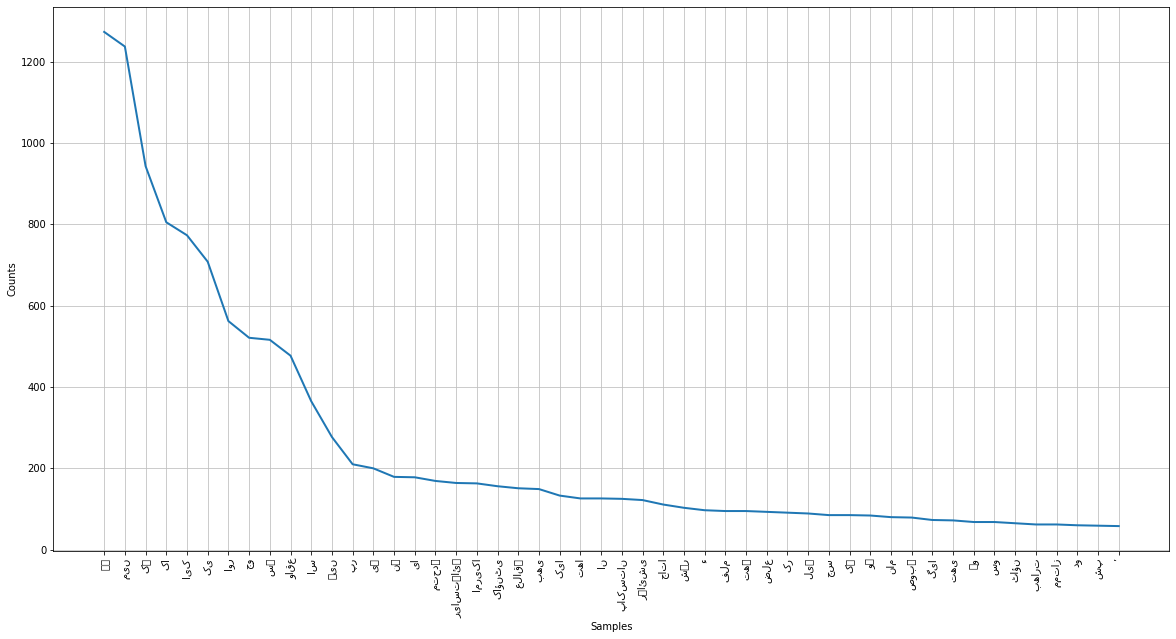

In [24]:
fdist = FreqDist(urdu_words)
plt.figure(figsize=(20, 10))
fdist.plot(50);

In [25]:
urdu_words[:10]

['زیورخ',
 'کیلیفورنیا',
 'ریاستہائے',
 'متحدہ',
 'امریکا',
 'کا',
 'ایک',
 'انانکارپوریٹڈ',
 'علاقہ',
 'جو']

In [31]:
unique_words = np.unique(urdu_words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [32]:
unique_word_index

{'ء': 0,
 'آ': 1,
 'آئر': 2,
 'آئرائی': 3,
 'آئرس': 4,
 'آئرش': 5,
 'آئرلینڈ': 6,
 'آئس': 7,
 'آئن': 8,
 'آئون': 9,
 'آئی': 10,
 'آئینہ': 11,
 'آئیوس': 12,
 'آئیووا': 13,
 'آئیں': 14,
 'آئے': 15,
 'آب': 16,
 'آباد': 17,
 'آبادی': 18,
 'آبادیات': 19,
 'آبادیاتی': 20,
 'آبادیوں': 21,
 'آبرود': 22,
 'آبشار': 23,
 'آبشاروں': 24,
 'آبنائے': 25,
 'آتا': 26,
 'آتش': 27,
 'آتشزدگی': 28,
 'آتشی': 29,
 'آتی': 30,
 'آتیں': 31,
 'آتے': 32,
 'آثار': 33,
 'آج': 34,
 'آجائیں': 35,
 'آجاتا': 36,
 'آجانا': 37,
 'آخر': 38,
 'آخری': 39,
 'آدبودووا': 40,
 'آدمز': 41,
 'آدمی': 42,
 'آدھی': 43,
 'آدیامان': 44,
 'آذربائجان': 45,
 'آذربائیجان': 46,
 'آر': 47,
 'آرائش': 48,
 'آرادان': 49,
 'آرال': 50,
 'آرام': 51,
 'آراین': 52,
 'آرایک': 53,
 'آرتوین': 54,
 'آرتھر': 55,
 'آرتھوڈوکس': 56,
 'آرزو': 57,
 'آرمینیا': 58,
 'آرٹسشعبہ': 59,
 'آرکنساس': 60,
 'آریہ': 61,
 'آزاد': 62,
 'آزادی': 63,
 'آزار': 64,
 'آزما': 65,
 'آزہیگوڈی': 66,
 'آسام': 67,
 'آسان': 68,
 'آسمان': 69,
 'آسٹریلیا': 70,
 'آسگوڈ': 71,
 'آغاز': 7

In [33]:
len(unique_word_index)

5778

In [34]:
unique_words[:20]

array(['ء', 'آ', 'آئر', 'آئرائی', 'آئرس', 'آئرش', 'آئرلینڈ', 'آئس', 'آئن',
       'آئون', 'آئی', 'آئینہ', 'آئیوس', 'آئیووا', 'آئیں', 'آئے', 'آب',
       'آباد', 'آبادی', 'آبادیات'], dtype='<U24')

## Separation of Target and Variables 

In [35]:
WORD_LENGTH = 3
prev_words = []
next_words = []
for i in range(len(urdu_words) - WORD_LENGTH):
    prev_words.append(urdu_words[i:i + WORD_LENGTH])
    next_words.append(urdu_words[i + WORD_LENGTH])
print(prev_words[:5])
print(next_words[:5])

[['زیورخ', 'کیلیفورنیا', 'ریاستہائے'], ['کیلیفورنیا', 'ریاستہائے', 'متحدہ'], ['ریاستہائے', 'متحدہ', 'امریکا'], ['متحدہ', 'امریکا', 'کا'], ['امریکا', 'کا', 'ایک']]
['متحدہ', 'امریکا', 'کا', 'ایک', 'انانکارپوریٹڈ']


In [36]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    y[i, unique_word_index[next_words[i]]] = 1

In [37]:
len(X), len(y), X.shape, y.shape

(29150, 29150, (29150, 3, 5778), (29150, 5778))

In [148]:
# FSM

In [45]:
model = Sequential()
model.add(LSTM(32, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation("softmax"))

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
history=model.fit(X,y, epochs=100, batch_size=64, validation_split=0.05).history

NameError: ignored

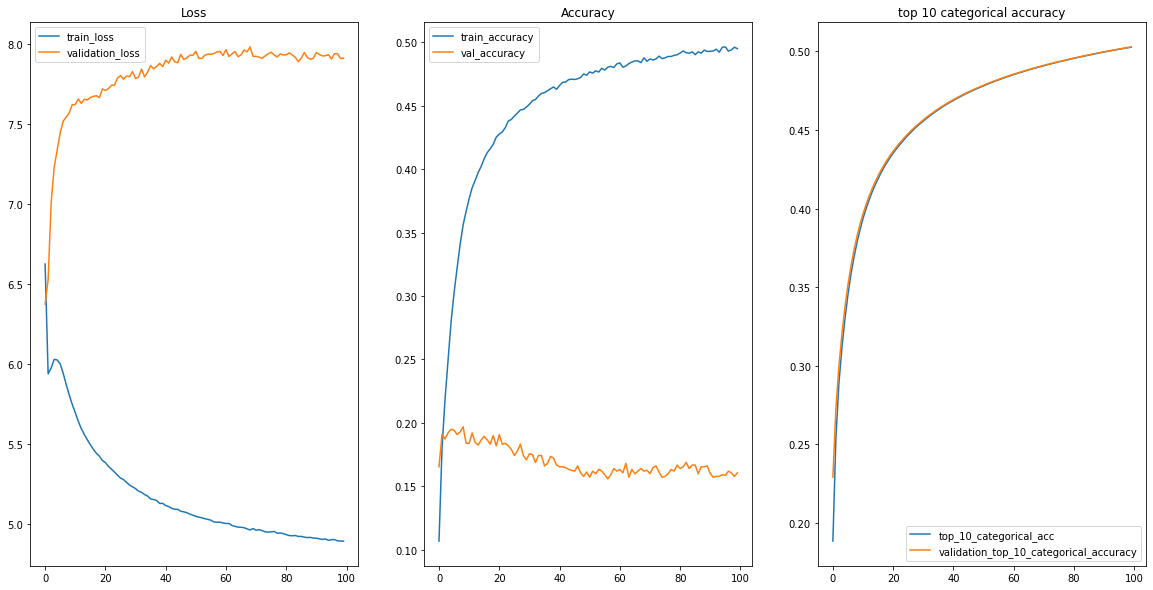

In [150]:
train_loss = history['loss']
train_acc = history['accuracy']
val_loss =history['val_loss']
val_acc = history['val_accuracy']
train_top_acc = history["top_k_categorical_accuracy"]
val_top_acc = history["val_top_k_categorical_accuracy"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.plot(train_loss, label='train_loss')
ax1.plot(val_loss, label='validation_loss')
ax1.set_title("Loss")
ax1.legend()

ax2.plot(train_acc, label='train_accuracy')
ax2.plot(val_acc, label='val_accuracy')
ax2.set_title("Accuracy")
ax2.legend()

ax3.plot(train_top_acc, label='top_10_categorical_acc')
ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
ax3.set_title("top 10 categorical accuracy")
ax3.legend()

# First Model

In [152]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='relu'))
model.add(Activation("softmax"))
print(model.summary())

optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 128)            3024384   
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5778)              745362    
_________________________________________________________________
activation_2 (Activation)    (None, 5778)              0         
Total params: 3,901,330
Trainable params: 3,901,330
Non-trainable params: 0
____________________________________________

In [47]:
results=model.fit(X,y, epochs=100, batch_size=64, validation_split=0.05).history

NameError: ignored

In [51]:
def graph(results):
  train_loss = results['loss']
  train_acc = results['accuracy']
  train_top_acc = results["top_k_categorical_accuracy"]
  val_loss =results['val_loss']
  val_acc = results['val_accuracy']
  val_top_acc = results["val_top_k_categorical_accuracy"]

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

  ax1.plot(train_loss, label='train_loss')
  ax1.plot(val_loss, label='validation_loss')
  ax1.set_title("Loss")
  ax1.legend()

  ax2.plot(train_acc, label='train_accuracy')
  ax2.plot(val_acc, label='val_accuracy')
  ax2.set_title("Accuracy")
  ax2.legend()

  ax3.plot(train_top_acc, label='top_10_categorical_acc')
  ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
  ax3.set_title("Top 10 categorical accuracy")
  ax3.legend()

In [ ]:
# change learning rate and number of nodes

In [50]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='relu'))
model.add(Activation("softmax"))
print(model.summary())

optimizer = RMSprop(learning_rate=0.01)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)
results=model.fit(X,y, epochs=100, batch_size=64, validation_split=0.05).history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 256)            6179840   
_________________________________________________________________
dropout (Dropout)            (None, 3, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5778)              1484946   
_________________________________________________________________
activation (Activation)      (None, 5778)              0         
Total params: 8,190,098
Trainable params: 8,190,098
Non-trainable params: 0
______________________________________________

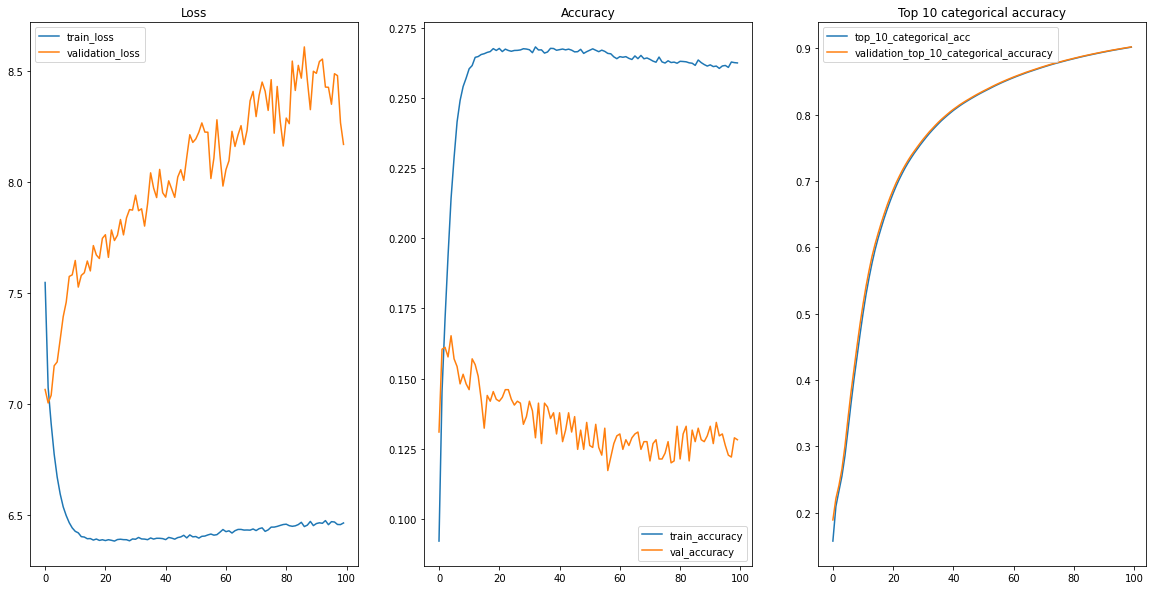

In [52]:
graph(results)

In [55]:
#batch size=10, lr=0.001(best)

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='relu'))
model.add(Activation("softmax"))
print(model.summary())

optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)
results=model.fit(X,y, epochs=100, batch_size=10, validation_split=0.05).history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 256)            6179840   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5778)              1484946   
_________________________________________________________________
activation_1 (Activation)    (None, 5778)              0         
Total params: 8,190,098
Trainable params: 8,190,098
Non-trainable params: 0
____________________________________________

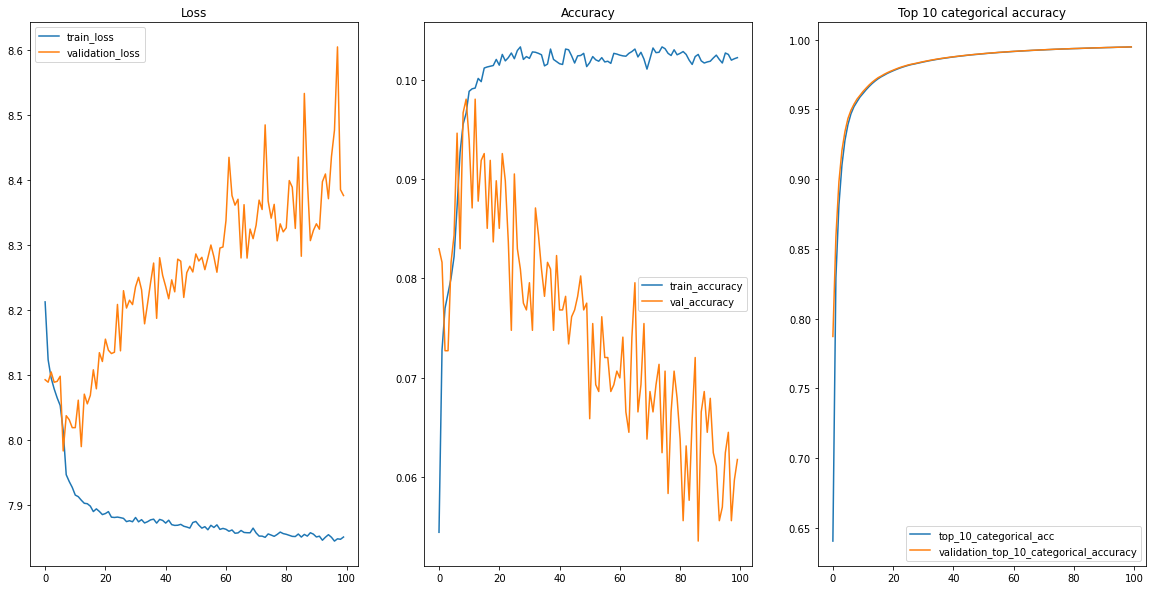

In [57]:
graph(results)

In [40]:
# Grid Search

In [47]:
def model(optimizer="RMSprop(learning_rate=0.001)"):
  model = Sequential()
  model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(256))
  model.add(Dropout(0.3))
  model.add(Dense(y.shape[1], activation='relu'))
  model.add(Activation("softmax"))
  # print(model.summary())
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

  return model

In [48]:
model = KerasClassifier(build_fn=model, verbose=1)

In [49]:

param_grid = {
    'epochs': [50,100,150], 
    'batch_size':[32,62,128],
    'optimizer':['RMSprop', 'Adam'],
    # 'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0]
}

kfold_splits = 3
grid = GridSearchCV(model,  
                    n_jobs=1, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid)

In [ ]:
grid_result = grid.fit(X, y) 

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
608/608 [==============================] - 39s 22ms/step - loss: 8.2118 - accuracy: 0.0417 - top_k_categorical_accuracy: 0.1117
Epoch 2/50
608/608 [==============================] - 13s 21ms/step - loss: 7.9996 - accuracy: 0.0710 - top_k_categorical_accuracy: 0.1255
Epoch 3/50
608/608 [==============================] - 13s 21ms/step - loss: 7.9518 - accuracy: 0.0923 - top_k_categorical_accuracy: 0.1719
Epoch 4/50
608/608 [==============================] - 13s 21ms/step - loss: 7.8937 - accuracy: 0.1019 - top_k_categorical_accuracy: 0.2788
Epoch 5/50
608/608 [==============================] - 13s 22ms/step - loss: 7.8809 - accuracy: 0.1031 - top_k_categorical_accuracy: 0.3840
Epoch 6/50
608/608 [==============================] - 13s 21ms/step - loss: 7.8646 - accuracy: 0.1033 - top_k_categorical_accuracy: 0.4673
Epoch 7/50
608/608 [==============================] - 13s 21ms/step - loss: 7.8202 - accuracy: 0.1063 - top_k_categorical_accuracy: 0.5334
Epoch 8/50
608/608 [=======

In [ ]:
model.save('urdu-gs-model.h5')
pickle.dump(history, open("ugshistory.p", "wb"))

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predictions

In [ ]:
x = np.zeros((1, WORD_LENGTH, len(unique_words)))
text="اور بھی بے"
for t, word in enumerate(text.split()):
    print(word)
    x[0, t, unique_word_index[word]] = 1
print(x)

اور
بھی
بے
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("اور بھی بے")

اور
بھی
بے


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
import heapq
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [ ]:
q =  input("ENTER TEXT: ")
# print("correct sentence: ",q)
seq =  q #" ".join(q)#tokenized.tokenize(q.lower())[0:3])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 10))

ENTER TEXT: امریکا کا ایک
Sequence:  امریکا کا ایک
امریکا
کا
ایک
next possible words:  ['جو', 'کا', 'ہے', 'ریاستہائے', 'آ', 'آئر', 'آئرائی', 'آئرلینڈ', 'آئس', 'آئی']


In [46]:
while True:pass

KeyboardInterrupt: ignored